In [1]:
%run ../../utils/commonImports.py
%run ../../utils/tradingImports.py
%matplotlib inline

from base import supres, BaseStrategy
from trading.walletHistory import WalletHistory
from exputils import *

# Load Data

In [2]:
# dropbox_dir = 'D:\\Dropbox\\My work\\krypl-project'
dropbox_dir = '/Users/david.vesely/Dropbox/My work/krypl-project'
features = ['support']

In [3]:
pairs = pd.read_csv('selected-pairs.tsv', header=None)[0].tolist()
train_dict = {pair: read_train(pair, dropbox_dir) for pair in pairs}
test_dict = {pair: read_test(pair, dropbox_dir) for pair in pairs}
data_dict = {pair: read_all(pair, dropbox_dir) for pair in pairs}

In [4]:
ohlc_supports_test_dict = load_model('ohlc_supports_test.pkl')
ohlc_supports_train_dict = load_model('ohlc_supports_train.pkl')

def _append(pair, w_size):
    return ohlc_supports_train_dict[pair][w_size] + ohlc_supports_test_dict[pair][w_size]

def _w_sizes(pair):
    return ohlc_supports_train_dict[pair].keys()

ohlc_supports_dict = {pair: {w_size: _append(pair, w_size) for w_size in _w_sizes(pair)} for pair in pairs}

In [5]:
rpath = os.path.join(dropbox_dir,'result', 'base-strategy3-learn-01.pkl')
results = pd.read_pickle(rpath)

days = 365 * 2
results['tradesPerDay'] = results['numberOfTrades'] / days
results['profitPerDay'] = results['totalProfit'] / days

In [6]:
print(results.shape)
results.head()

(6650, 18)


,pair,window_size,stop_loss,_return,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,avgTimeToClose,minTimeToClose,maxTimeToClose,tradesPerDay,profitPerDay
0,BTC_ETH,4,0.0100,0.0100,100.0000,"4,765.0000",-99.9988,-0.0210,59.6642,0.0182,-0.0789,0.3409,99.9989,1.3455,0.2500,33.7500,6.5274,-0.1370
1,BTC_ETH,4,0.0200,0.0100,100.0000,"3,982.0000",-96.7339,-0.0243,81.8935,0.1384,-0.7603,0.8235,97.7354,2.5401,0.2500,86.5000,5.4548,-0.1325
2,BTC_ETH,4,0.0200,0.0200,100.0000,"4,627.0000",-99.8442,-0.0216,79.3819,0.0707,-0.3767,0.7222,99.8460,2.4201,0.2500,86.5000,6.3384,-0.1368
3,BTC_ETH,4,0.0200,0.0300,100.0000,"4,977.0000",-99.9862,-0.0201,76.3914,0.0466,-0.2360,0.6394,99.9862,2.3435,0.2500,86.5000,6.8178,-0.1370
4,BTC_ETH,4,0.0100,0.0200,100.0000,"5,481.0000",-100.0000,-0.0182,58.2011,0.0103,-0.0580,0.2470,100.0000,1.2869,0.2500,33.7500,7.5082,-0.1370


# Select Params

Intersting formula

E= [1+ (W/L)] x P – 1

Where:

- W means the size of your average win
- L means the size of your average loss
- P means winning rate

In [7]:
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

In [8]:
results['zTotalProfit'] = min_max(results['totalProfit'])
results['zWinPercentage'] = min_max(results['winPercentage'])
results['zAvgLossTrade'] = min_max(results['avgLossTrade'])
results['meanStats'] = (results['zTotalProfit'] + 
                        (3 * results['zWinPercentage']) + 
                        results['zAvgLossTrade'] * (1 - results['winPercentage'] / 100)) / 3

In [9]:
selected_params = pd.DataFrame()
for pair in pairs:
    p_results = results[results['pair'] == pair]
    p_results = reset_index_hard(p_results).copy()
    row = p_results.query('totalProfit > 0')\
        .query('-avgLossTrade <= 1.5*avgWinTrade')\
        .query('stop_loss < 0.06')\
        .sort_values('meanStats', ascending=False).iloc[0, :]
    selected_params = selected_params.append(row)

In [10]:
cols = ['pair', 'window_size', 'stop_loss', '_return', 'tradesPerDay', 
        'totalProfit', 'maxTimeToClose', 'winPercentage', 'avgLossTrade', 'avgWinTrade']
selected_params[cols]

,pair,window_size,stop_loss,_return,tradesPerDay,totalProfit,maxTimeToClose,winPercentage,avgLossTrade,avgWinTrade
255,BTC_ETH,30.0000,0.0200,0.0100,0.3096,119.2752,34.2500,76.1062,-1.8039,1.2598
310,BTC_XRP,48.0000,0.0300,0.0200,0.1014,100.2373,18.7500,89.1892,-2.7062,1.8468
305,BTC_LTC,48.0000,0.0200,0.0100,0.1342,64.1803,123.5000,80.6122,-1.8039,1.2463
305,BTC_XMR,48.0000,0.0200,0.0100,0.1315,37.7838,23.7500,68.7500,-1.7674,1.3758
310,BTC_STR,48.0000,0.0300,0.0100,0.1068,97.4979,111.7500,80.7692,-2.7062,2.1919
321,BTC_DASH,48.0000,0.0500,0.0200,0.1151,136.3491,102.7500,94.0476,-1.6235,1.8287
315,BTC_BTS,48.0000,0.0400,0.0100,0.1123,168.7895,82.7500,90.2439,-3.6085,2.6710
322,BTC_FCT,48.0000,0.0500,0.0300,0.1370,159.7889,24.7500,86.0000,-3.2218,2.3825
317,BTC_XEM,48.0000,0.0400,0.0300,0.1233,95.7084,40.7500,81.1111,-2.9716,2.0031
320,BTC_MAID,48.0000,0.0500,0.0100,0.0986,164.2616,35.7500,90.2778,-4.5107,3.0129


# Wallet history

In [20]:
price_dict_test = {pair: test_dict[pair]['close'].tolist() for pair in pairs}

In [21]:
price_dict = price_dict_test

In [30]:
from itertools import product
from multiprocessing import Manager

def profolio_value_f(args):
    price_dict, (ts, wallet) = args
    ts = int(ts)
    btc = wallet.get('btc', 0)
    for currency, amount in wallet.items():
        if currency == 'btc' or amount == 0:
            continue
        data = price_dict[f'BTC_{currency.upper()}']
        price = data[ts]
        btc += amount * price

    return ts, btc


def portfolio_value(strategy, data_dict, pair=None):
    def _get(ts, col='close'):
        t = ts if ts < data.shape[0] else data.shape[0]-1
        row = data.iloc[t, :]
        return row[col]
    
    data = data_dict[pair]
    manager = Manager()
    price_dict = manager.dict({pair: data_dict[pair]['close'].tolist() for pair in pairs})
    transactions = strategy.exchange.transactions
    history = WalletHistory({'btc': 100}).history(transactions)
    args = product([price_dict], history.items())
    results = run_parallel(profolio_value_f, args)
    df = pd.DataFrame(results, columns=['timestamp', 'btc'])\
        .sort_values('timestamp')
    df = reset_index_hard(df)
    df['btc_return_%'] = ((df['btc'] / 100) - 1) * 100
    if pair is not None:
        df['hold'] = df['timestamp'].apply(_get)
        first_price = _get(0)
        df['hold_return_%'] = ((df['hold'] / first_price) - 1) * 100
    df['index'] = df['timestamp']
    df['timestamp'] = df['index'].apply(lambda ts: _get(ts, 'timestamp'))
    return df

In [31]:
import matplotlib.dates as md
def plot_portfolio_value(df, step=10, title='Portfolio return over time'):
    
    f = plt.figure(figsize=[12, 6])

    df['date'] = df['timestamp'].apply(dt.datetime.fromtimestamp)
    selected = df.iloc[[i for j, i in enumerate(df.index) if j % step == 0], :]\
        .sort_values('timestamp')\
        .reset_index()
    xdates = selected['date']
    ax = sns.lineplot(xdates, selected['btc_return_%'], label='strategy', marker='o')
    if 'hold' in df.columns:
        ax = sns.lineplot(xdates, selected['hold_return_%'], label='hold', marker='o')
    
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(MaxNLocator(6))

    plt.title(title, fontproperties=title_font)
    plt.xlabel('date', fontproperties=axis_font)
    plt.ylabel('return (%)', fontproperties=axis_font)
    plt.show()

# Test Selected

In [32]:
def get_strategy(data, pair, willing_loss, _return):
    contract_pair = ContractPair.new(*[x.lower() for x in pair.split('_')])
    dm = OhlcDataManager(data[['open', 'low', 'high', 'close']], data[features])
    wallet = {'btc': 100}
    exchange = BackTestExchange(dm, wallet, 0.0025)
    strategy = BaseStrategy(exchange, 
                            dm, 
                            contract_pair, 
                            willing_loss=willing_loss,  
                            target_return=_return
                           )
    strategy.trade()
    return strategy

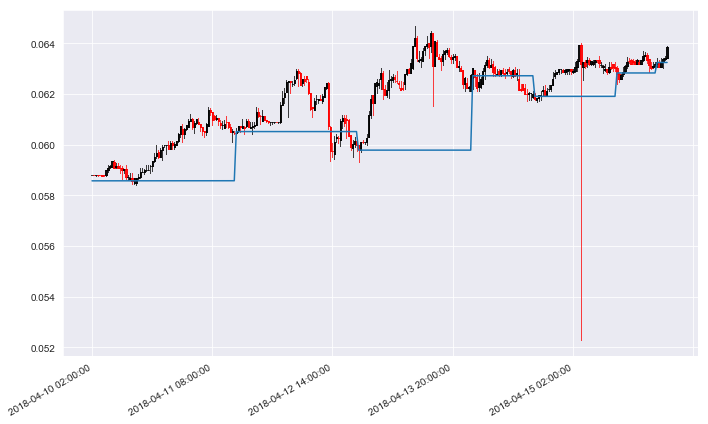

In [33]:
pair = 'BTC_ETH'
data = test_dict[pair]
data['support'] = ohlc_supports_test_dict[pair][12]
data = data.query('date >= "2018-04-10" and date <= "2018-04-16"').reset_index()
plot_candles(data)
plt.plot(data['support'])

                    btc
startAmount    100.0000
numberOfTrades 146.0000
totalProfit     91.2808
avgProfit        0.6252
winPercentage   89.7260
avgWinTrade      0.9034
avgLossTrade    -1.8039
profitFactor     4.3734
maxDrawdown      2.9654
avgTimeToClose   8.5411
minTimeToClose   0.2500
maxTimeToClose 121.7500


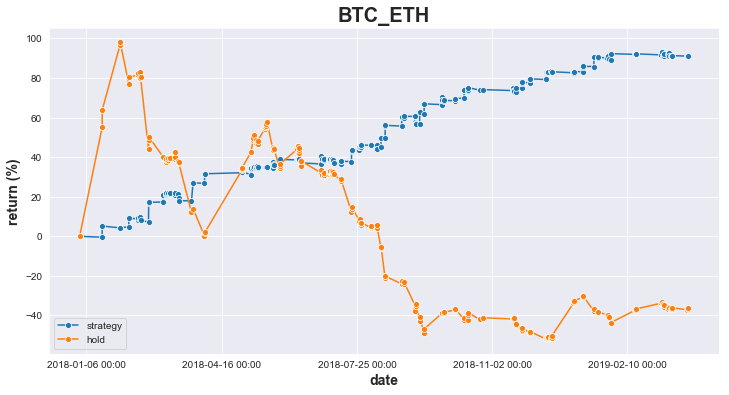

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  68.0000
totalProfit     72.2395
avgProfit        1.0623
winPercentage   92.6471
avgWinTrade      1.3328
avgLossTrade    -2.3453
profitFactor     7.1604
maxDrawdown      4.7672
avgTimeToClose   7.0074
minTimeToClose   0.2500
maxTimeToClose  31.7500


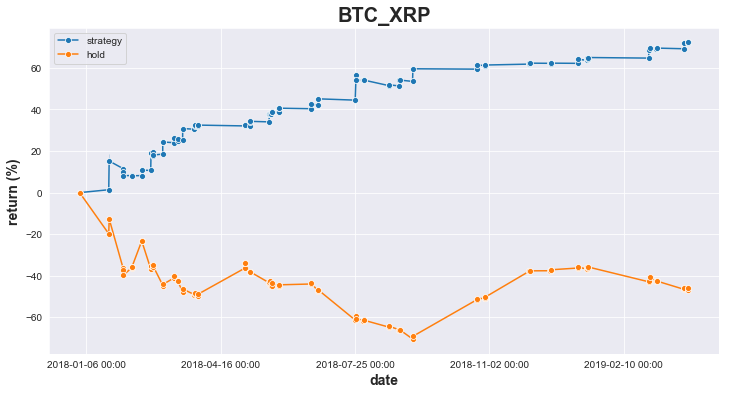

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  74.0000
totalProfit     34.2808
avgProfit        0.4633
winPercentage   78.3784
avgWinTrade      1.0697
avgLossTrade    -1.7351
profitFactor     2.2349
maxDrawdown     10.8115
avgTimeToClose   9.2939
minTimeToClose   0.2500
maxTimeToClose 106.2500


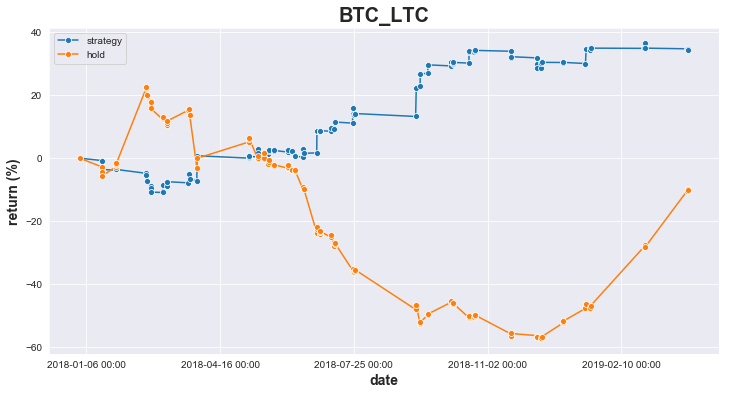

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  78.0000
totalProfit     47.8891
avgProfit        0.6140
winPercentage   89.7436
avgWinTrade      0.8903
avgLossTrade    -1.8039
profitFactor     4.3184
maxDrawdown      3.5439
avgTimeToClose   5.1314
minTimeToClose   0.2500
maxTimeToClose  26.5000


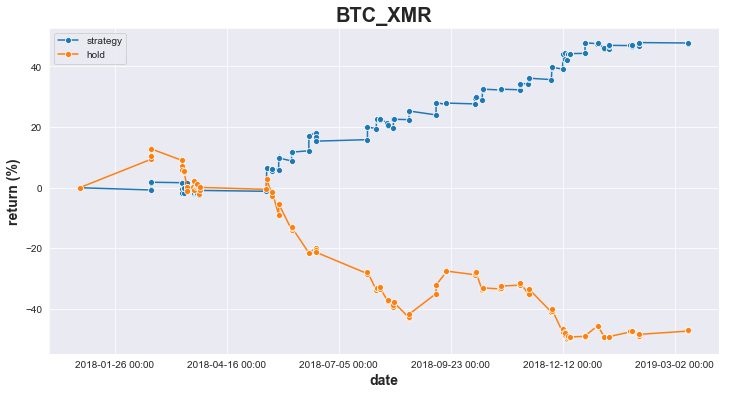

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  64.0000
totalProfit     81.2499
avgProfit        1.2695
winPercentage   96.8750
avgWinTrade      1.3978
avgLossTrade    -2.7062
profitFactor    16.0118
maxDrawdown      2.1603
avgTimeToClose   6.2812
minTimeToClose   0.2500
maxTimeToClose  18.7500


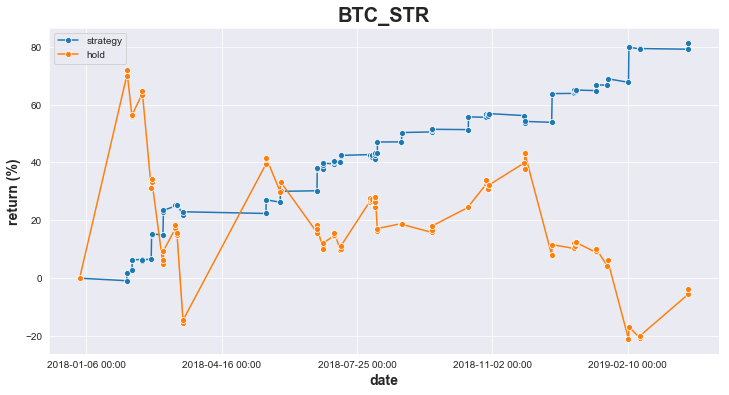

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 120.0000
totalProfit     71.4942
avgProfit        0.5958
winPercentage   95.8333
avgWinTrade      0.7864
avgLossTrade    -3.7889
profitFactor     4.7739
maxDrawdown      5.1647
avgTimeToClose   7.4792
minTimeToClose   0.2500
maxTimeToClose  56.2500


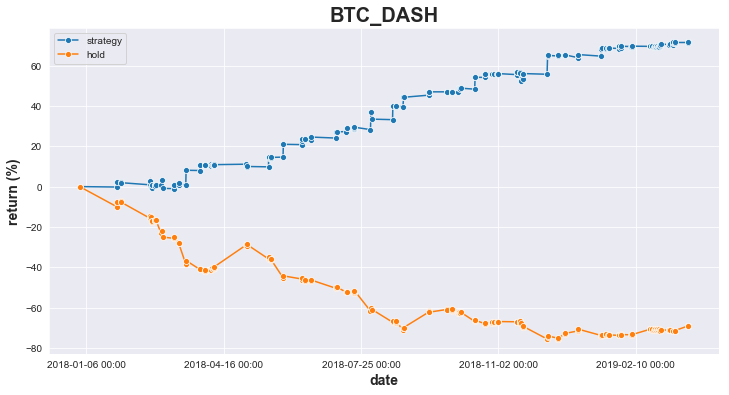

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  52.0000
totalProfit     80.3400
avgProfit        1.5450
winPercentage   96.1538
avgWinTrade      1.7511
avgLossTrade    -3.6085
profitFactor    12.1322
maxDrawdown      2.7999
avgTimeToClose   6.3846
minTimeToClose   0.5000
maxTimeToClose  37.7500


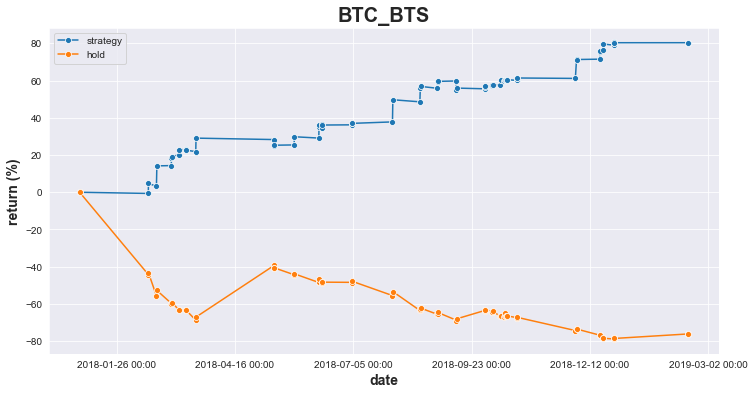

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  72.0000
totalProfit    122.8296
avgProfit        1.7060
winPercentage   95.8333
avgWinTrade      1.9240
avgLossTrade    -3.3077
profitFactor    13.3781
maxDrawdown      4.4660
avgTimeToClose   4.3507
minTimeToClose   0.2500
maxTimeToClose  41.7500


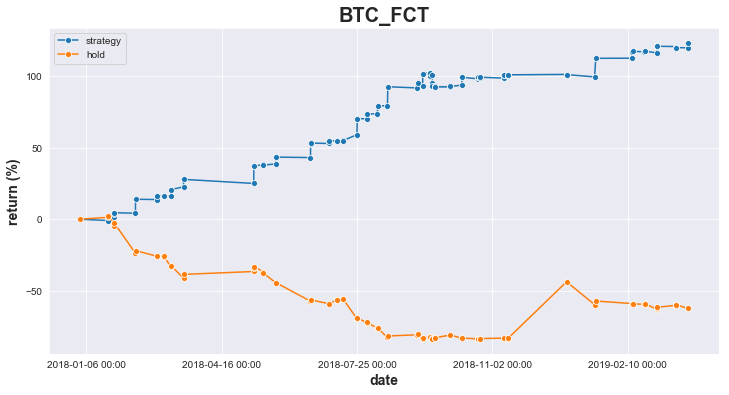

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  84.0000
totalProfit    107.4744
avgProfit        1.2795
winPercentage   88.0952
avgWinTrade      1.7571
avgLossTrade    -2.2551
profitFactor     5.7659
maxDrawdown     10.6660
avgTimeToClose   8.0119
minTimeToClose   0.2500
maxTimeToClose  49.7500


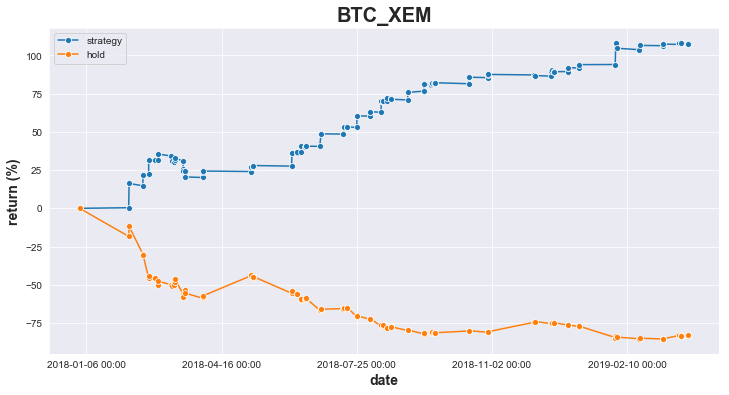

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  50.0000
totalProfit     95.6790
avgProfit        1.9136
winPercentage   98.0000
avgWinTrade      2.0447
avgLossTrade    -4.5107
profitFactor    22.2115
maxDrawdown      3.3589
avgTimeToClose   6.8200
minTimeToClose   0.2500
maxTimeToClose  39.5000


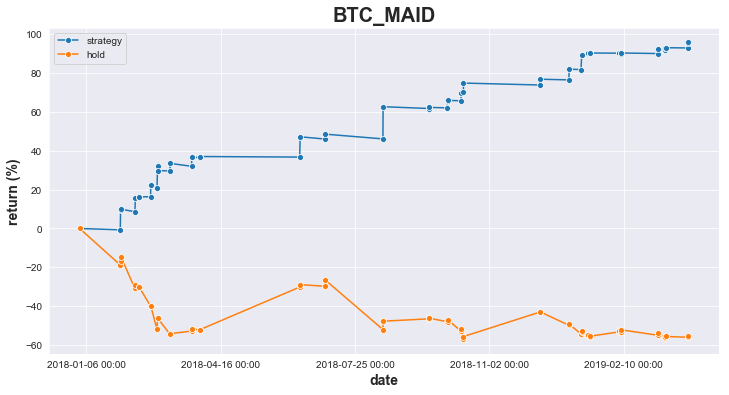

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 226.0000
totalProfit    119.3685
avgProfit        0.5282
winPercentage   91.1504
avgWinTrade      0.7196
avgLossTrade    -1.4430
profitFactor     5.1360
maxDrawdown      2.7966
avgTimeToClose   6.2942
minTimeToClose   0.2500
maxTimeToClose 156.7500


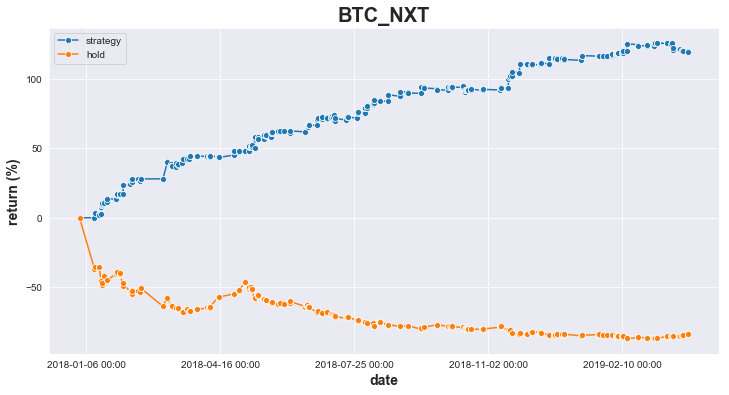

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  50.0000
totalProfit     63.1861
avgProfit        1.2637
winPercentage   88.0000
avgWinTrade      1.8871
avgLossTrade    -3.3077
profitFactor     4.1838
maxDrawdown      7.6421
avgTimeToClose  10.7150
minTimeToClose   0.2500
maxTimeToClose 102.2500


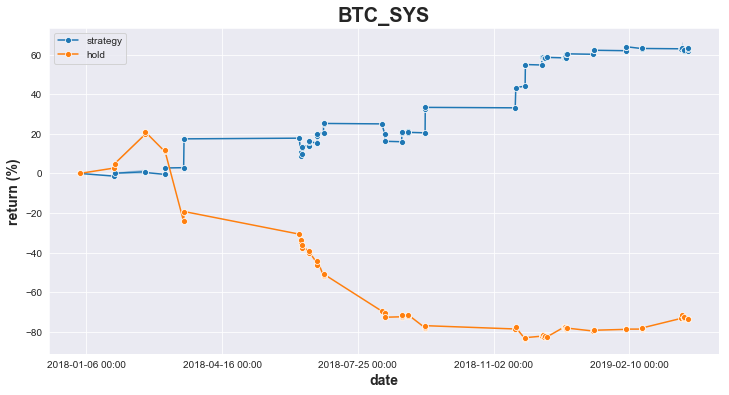

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 178.0000
totalProfit    164.4045
avgProfit        0.9236
winPercentage   91.5730
avgWinTrade      1.2687
avgLossTrade    -2.8265
profitFactor     4.8777
maxDrawdown     14.7828
avgTimeToClose   4.2388
minTimeToClose   0.2500
maxTimeToClose 208.2500


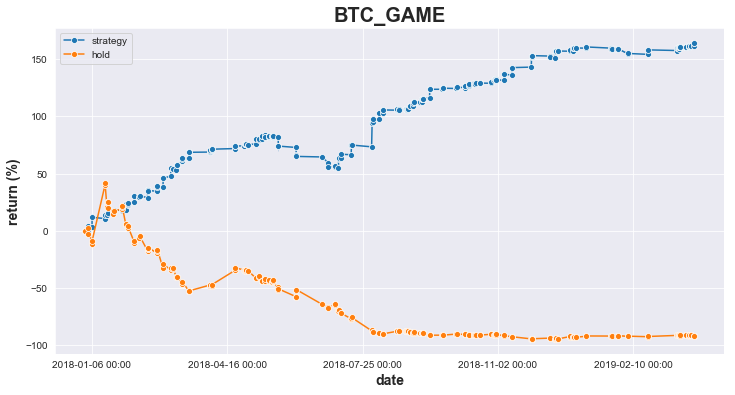

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  46.0000
totalProfit     59.5748
avgProfit        1.2951
winPercentage   89.1304
avgWinTrade      1.8271
avgLossTrade    -3.0671
profitFactor     4.8848
maxDrawdown      4.3269
avgTimeToClose   8.7500
minTimeToClose   0.2500
maxTimeToClose  42.2500


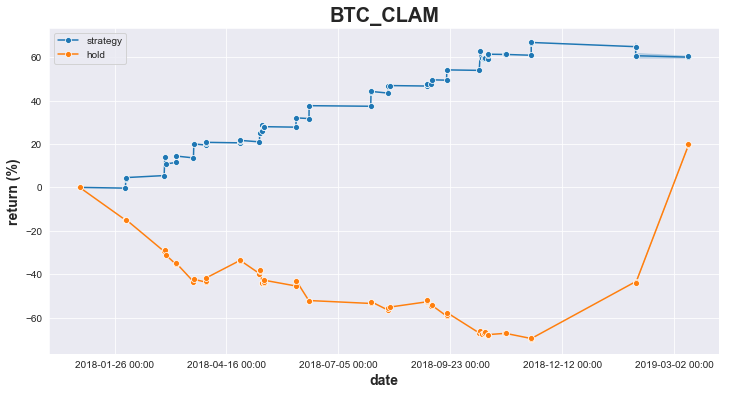

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 136.0000
totalProfit    114.7432
avgProfit        0.8437
winPercentage   89.7059
avgWinTrade      1.1327
avgLossTrade    -1.6751
profitFactor     5.8929
maxDrawdown      7.3242
avgTimeToClose   4.0993
minTimeToClose   0.2500
maxTimeToClose  28.2500


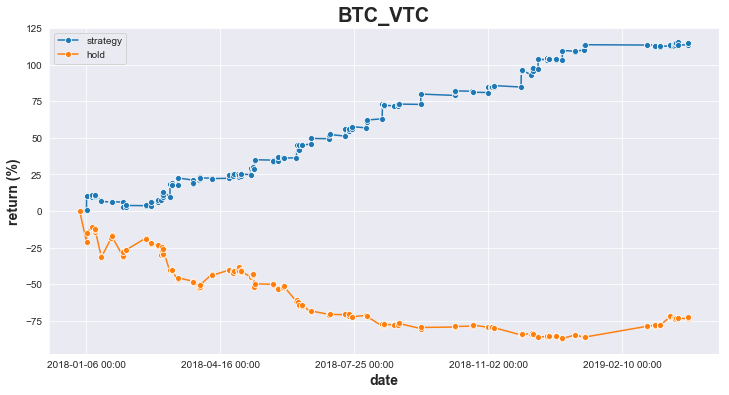

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 186.0000
totalProfit    168.0020
avgProfit        0.9032
winPercentage   94.6237
avgWinTrade      1.1083
avgLossTrade    -2.7062
profitFactor     7.2080
maxDrawdown      7.4985
avgTimeToClose   4.6976
minTimeToClose   0.2500
maxTimeToClose  39.7500


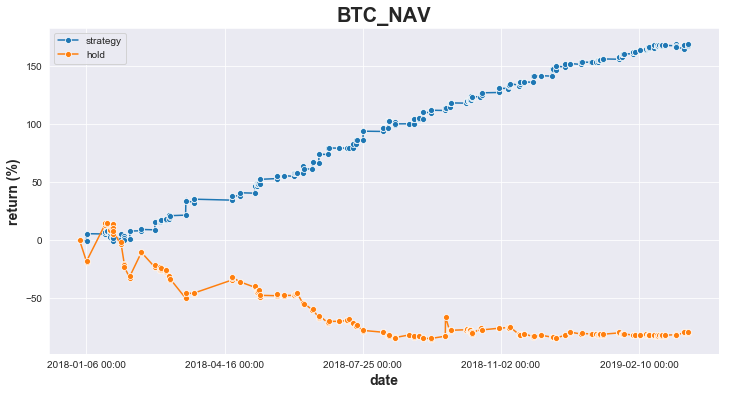

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  62.0000
totalProfit     96.6214
avgProfit        1.5584
winPercentage   88.7097
avgWinTrade      2.3308
avgLossTrade    -4.5107
profitFactor     4.0601
maxDrawdown      8.2748
avgTimeToClose  12.2379
minTimeToClose   0.2500
maxTimeToClose 151.7500


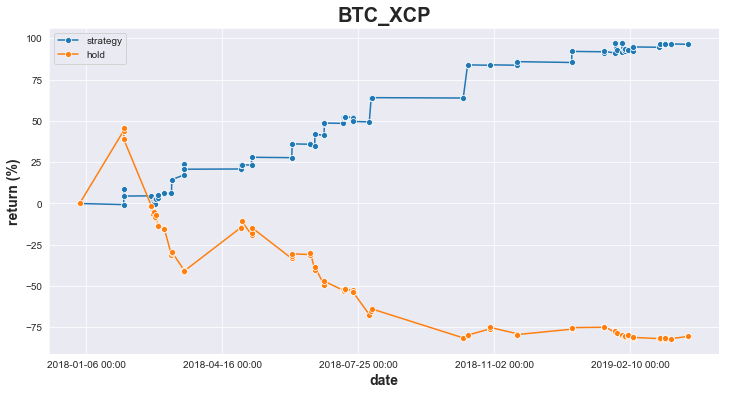

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 170.0000
totalProfit    145.3830
avgProfit        0.8552
winPercentage   94.7059
avgWinTrade      1.0543
avgLossTrade    -2.7062
profitFactor     6.9691
maxDrawdown      4.6689
avgTimeToClose   5.1103
minTimeToClose   0.2500
maxTimeToClose  86.0000


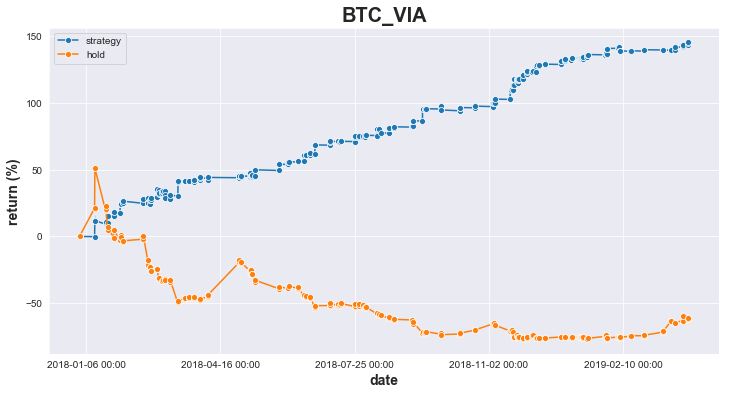

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  26.0000
totalProfit     59.5744
avgProfit        2.2913
winPercentage   88.4615
avgWinTrade      3.1785
avgLossTrade    -4.5107
profitFactor     5.4024
maxDrawdown      5.9571
avgTimeToClose  22.0769
minTimeToClose   0.2500
maxTimeToClose 223.2500


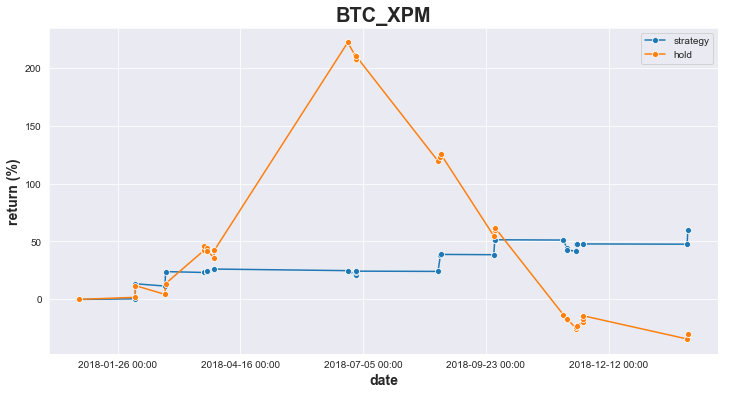

-----------------------------------------


In [35]:
for i in range(len(selected_params)):
    row = selected_params.iloc[i, :]
    pair = row['pair']
    window_size = row['window_size']
    willing_loss = row['stop_loss']
    _return = row['_return']

    data = test_dict[pair]
    data['support'] = ohlc_supports_test_dict[pair][window_size]

    strategy = get_strategy(data, pair, willing_loss, _return)
    print(strategy.stats('btc').report())
    df = portfolio_value(strategy, test_dict, pair)
    plot_portfolio_value(df, 1, pair)
    print('-----------------------------------------')